# Using Text Data with EvalML

In this demo, we will show you how to use EvalML to build models which use text data. 

In [1]:
import evalml
from evalml import AutoMLSearch

## Dataset

We will be utilizing a dataset of SMS text messages, some of which are categorized as spam, and others which are not ("ham"). This dataset is originally from [Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset), but modified to produce a slightly more even distribution of spam to ham.

In [2]:
%%time
from urllib.request import urlopen
import pandas as pd

input_data = urlopen('https://featurelabs-static.s3.amazonaws.com/spam_text_messages_modified.csv')
data = pd.read_csv(input_data)

X = data.drop(['Category'], axis=1)
y = data['Category']

display(X.head())

,Message
0,Free entry in 2 a wkly comp to win FA Cup fina...
1,FreeMsg Hey there darling it's been 3 week's n...
2,WINNER!! As a valued network customer you have...
3,Had your mobile 11 months or more? U R entitle...
4,"SIX chances to win CASH! From 100 to 20,000 po..."


CPU times: user 27.7 ms, sys: 5.8 ms, total: 33.5 ms
Wall time: 265 ms


The ham vs spam distribution of the data is 3:1, so any machine learning model must get above 75% [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) in order to perform better than a trivial baseline model which simply classifies everything as ham. 

In [3]:
%%time
y.value_counts(normalize=True)

CPU times: user 1.45 ms, sys: 617 µs, total: 2.07 ms
Wall time: 1.52 ms


ham     0.750084
spam    0.249916
Name: Category, dtype: float64

## Search for best pipeline

In order to validate the results of the pipeline creation and optimization process, we will save some of our data as a holdout set.

In [4]:
%%time
X_train, X_holdout, y_train, y_holdout = evalml.preprocessing.split_data(X, y, problem_type='binary', test_size=0.2, random_state=0)

CPU times: user 18.4 ms, sys: 1.87 ms, total: 20.3 ms
Wall time: 19.1 ms


EvalML uses [Woodwork](https://woodwork.alteryx.com/en/stable/) to automatically detect which columns are text columns, so you can run search normally, as you would if there was no text data. We can print out the logical type of the `Message` column and assert that it is indeed inferred as a natural language column.

In [5]:
%%time
X_train.types

CPU times: user 844 µs, sys: 19 µs, total: 863 µs
Wall time: 864 µs


,Physical Type,Logical Type,Semantic Tag(s)
Data Column,,,
Message,string,NaturalLanguage,[]


Because the spam/ham labels are binary, we will use `AutoMLSearch(X_train=X_train, y_train=y_train, problem_type='binary')`. When we call `.search()`, the search for the best pipeline will begin. 

In [6]:
%%time
automl = AutoMLSearch(X_train=X_train, y_train=y_train,
                      problem_type='binary',
                      max_batches=1,
                      optimize_thresholds=True)

automl.search()

Numerical binary classification target classes must be [0, 1], got [ham, spam] instead
Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: lightgbm, random_forest, linear_model, extra_trees, catboost, xgboost, decision_tree



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/9) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 8.638
Batch 1: (2/9) Logistic Regression Classifier w/ Imp... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.170
High coefficient of variation (cv >= 0.2) within cross validation scores. Logistic Regression Classifier w/ Imputer + Text Featurization Component + Standard Scaler may not perform as estimated on unseen data.
Batch 1: (3/9) Random Forest Classifier w/ Imputer +... Elapsed:00:11
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.123
Batch 1: (4/9) XGBoost Classifier w/ Imputer + Text ... Elapsed:00:20
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.129
Batch 1: (5/9) CatBoost Classifier w/ Imputer + Text... Elapsed:00:29
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.519
Batch 1: (6/9) Elast

### View rankings and select pipeline

Once the fitting process is done, we can see all of the pipelines that were searched.

In [7]:
%%time
automl.rankings

CPU times: user 4.01 ms, sys: 265 µs, total: 4.28 ms
Wall time: 4.11 ms


,id,pipeline_name,score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,2,Random Forest Classifier w/ Imputer + Text Fea...,0.123494,0.129007,98.570392,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,3,XGBoost Classifier w/ Imputer + Text Featuriza...,0.128840,0.134231,98.508509,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,1,Logistic Regression Classifier w/ Imputer + Te...,0.170443,0.148005,98.026895,True,{'Imputer': {'categorical_impute_strategy': 'm...
3,7,LightGBM Classifier w/ Imputer + Text Featuriz...,0.171467,0.183049,98.015036,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,6,Extra Trees Classifier w/ Imputer + Text Featu...,0.219864,0.250778,97.454783,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,4,CatBoost Classifier w/ Imputer + Text Featuriz...,0.518860,0.522827,93.993496,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,5,Elastic Net Classifier w/ Imputer + Text Featu...,0.530537,0.561991,93.858323,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,8,Decision Tree Classifier w/ Imputer + Text Fea...,0.726110,0.595490,91.594296,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,0,Mode Baseline Binary Classification Pipeline,8.638305,8.623860,0.000000,False,{'Baseline Classifier': {'strategy': 'mode'}}


To select the best pipeline we can call `automl.best_pipeline`.

In [8]:
%%time
best_pipeline = automl.best_pipeline

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


### Describe pipeline

You can get more details about any pipeline, including how it performed on other objective functions.

In [9]:
%%time
automl.describe_pipeline(automl.rankings.iloc[0]["id"])

**********************************************************************
* Random Forest Classifier w/ Imputer + Text Featurization Component *
**********************************************************************

Problem Type: binary
Model Family: Random Forest

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. Text Featurization Component
	 * text_columns : ['Message']
3. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1

Training
Training for binary problems.
Total training time (including CV): 9.0 seconds

Cross Validation
----------------
             Log Loss Binary  MCC Binary   AUC  Precision    F1  Balanced Accuracy Binary  Accuracy Binary # Training # Validation
0                      0.129       0.885 0.979      0.937 0.912                     0.935            0.957   1594.000      797.000
1                      0.127  

CPU times: user 6.16 ms, sys: 13.1 ms, total: 19.2 ms
Wall time: 72.1 ms


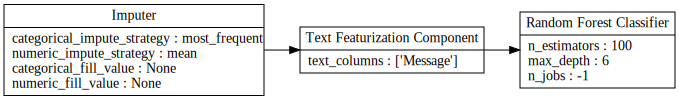

In [10]:
%%time
best_pipeline.graph()

Notice above that there is a `Text Featurization Component` as the second step in the pipeline. The Woodwork `DataTable` passed in to AutoML search recognizes that `'Message'` is a text column, and converts this text into numerical values that can be handled by the estimator.

## Evaluate on holdout

Now, we can score the pipeline on the holdout data using the core objectives for binary classification problems.

In [11]:
%%time
scores = best_pipeline.score(X_holdout, y_holdout,  objectives=evalml.objectives.get_core_objectives('binary'))
print(f'Accuracy Binary: {scores["Accuracy Binary"]}')

Accuracy Binary: 0.9732441471571907
CPU times: user 983 ms, sys: 138 ms, total: 1.12 s
Wall time: 1.11 s


As you can see, this model performs relatively well on this dataset, even on unseen data.

## Why encode text this way?

To demonstrate the importance of text-specific modeling, let's train a model with the same dataset, without letting `AutoMLSearch` detect the text column. We can change this by explicitly setting the data type of the `'Message'` column in Woodwork to `Categorical`.

In [12]:
%%time
import woodwork as ww
X_train_categorical = X_train.set_types(logical_types={'Message': 'Categorical'})

CPU times: user 12.3 ms, sys: 1.53 ms, total: 13.9 ms
Wall time: 12.3 ms


In [13]:
%%time
automl_no_text = AutoMLSearch(X_train=X_train, y_train=y_train,
                              problem_type='binary',
                              max_batches=1,
                              optimize_thresholds=True)

automl_no_text.search()

Numerical binary classification target classes must be [0, 1], got [ham, spam] instead
Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: lightgbm, random_forest, linear_model, extra_trees, catboost, xgboost, decision_tree



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/9) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 8.638
Batch 1: (2/9) Logistic Regression Classifier w/ Imp... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.170
High coefficient of variation (cv >= 0.2) within cross validation scores. Logistic Regression Classifier w/ Imputer + Text Featurization Component + Standard Scaler may not perform as estimated on unseen data.
Batch 1: (3/9) Random Forest Classifier w/ Imputer +... Elapsed:00:09
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.123
Batch 1: (4/9) XGBoost Classifier w/ Imputer + Text ... Elapsed:00:19
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.129
Batch 1: (5/9) CatBoost Classifier w/ Imputer + Text... Elapsed:00:28
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.519
Batch 1: (6/9) Elast

Like before, we can look at the rankings and pick the best pipeline.

In [14]:
%%time
automl_no_text.rankings

CPU times: user 3.85 ms, sys: 607 µs, total: 4.46 ms
Wall time: 3.9 ms


,id,pipeline_name,score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,2,Random Forest Classifier w/ Imputer + Text Fea...,0.123494,0.129007,98.570392,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,3,XGBoost Classifier w/ Imputer + Text Featuriza...,0.128840,0.134231,98.508509,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,1,Logistic Regression Classifier w/ Imputer + Te...,0.170443,0.148005,98.026895,True,{'Imputer': {'categorical_impute_strategy': 'm...
3,7,LightGBM Classifier w/ Imputer + Text Featuriz...,0.171467,0.183049,98.015036,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,6,Extra Trees Classifier w/ Imputer + Text Featu...,0.219864,0.250778,97.454783,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,4,CatBoost Classifier w/ Imputer + Text Featuriz...,0.518860,0.522827,93.993496,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,5,Elastic Net Classifier w/ Imputer + Text Featu...,0.530537,0.561991,93.858323,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,8,Decision Tree Classifier w/ Imputer + Text Fea...,0.726110,0.595490,91.594296,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,0,Mode Baseline Binary Classification Pipeline,8.638305,8.623860,0.000000,False,{'Baseline Classifier': {'strategy': 'mode'}}


In [15]:
%%time
best_pipeline_no_text = automl_no_text.best_pipeline

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 8.82 µs


Here, changing the data type of the text column removed the `Text Featurization Component` from the pipeline.

CPU times: user 3.48 ms, sys: 13 ms, total: 16.5 ms
Wall time: 71.7 ms


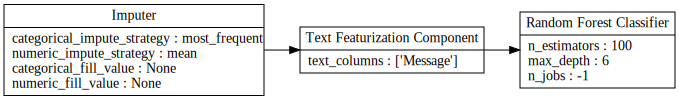

In [16]:
%%time
best_pipeline_no_text.graph()

In [17]:
%%time
automl_no_text.describe_pipeline(automl_no_text.rankings.iloc[0]["id"])

**********************************************************************
* Random Forest Classifier w/ Imputer + Text Featurization Component *
**********************************************************************

Problem Type: binary
Model Family: Random Forest

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. Text Featurization Component
	 * text_columns : ['Message']
3. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1

Training
Training for binary problems.
Total training time (including CV): 9.6 seconds

Cross Validation
----------------
             Log Loss Binary  MCC Binary   AUC  Precision    F1  Balanced Accuracy Binary  Accuracy Binary # Training # Validation
0                      0.129       0.885 0.979      0.937 0.912                     0.935            0.957   1594.000      797.000
1                      0.127  

In [18]:
%%time
# get standard performance metrics on holdout data
scores = best_pipeline_no_text.score(X_holdout, y_holdout, objectives=evalml.objectives.get_core_objectives('binary'))
print(f'Accuracy Binary: {scores["Accuracy Binary"]}')

Accuracy Binary: 0.9732441471571907
CPU times: user 970 ms, sys: 138 ms, total: 1.11 s
Wall time: 1.09 s


Without the `Text Featurization Component`, the `'Message'` column was treated as a categorical column, and therefore the conversion of this text to numerical features happened in the `One Hot Encoder`. The best pipeline encoded the top 10 most frequent "categories" of these texts, meaning 10 text messages were one-hot encoded and all the others were dropped. Clearly, this removed almost all of the information from the dataset, as we can see the `best_pipeline_no_text` did not beat the random guess of predicting "ham" in every case.